# Digital Earth Pacific mineral resource detection using Clay

This notebook applies the Clay model on imagery composites, specifically a Sentinel-2
Geometric Median [(GeoMAD)](https://docs.digitalearthafrica.org/en/latest/data_specs/GeoMAD_specs.html)
and Sentinel-1 mean composite. We will use
[Digital Earth Pacific's STAC API](https://stac-browser.staging.digitalearthpacific.org)
to obtain these datasets, and apply it on a mineral resource detection downstream task
on two levels:

1. Coarse level (chip of size 5.12km x 5.12km) - Using embeddings to get a general
semantic picture
2. Fine level (pixel of size 10m x 10m) - Using a fine-tuned decoder head to get
pixel-level segmentation masks

References:
- https://github.com/digitalearthpacific/mineral-resource-detection
- https://github.com/Clay-foundation/model/discussions/140

In [ ]:
cd ../dep/model

In [21]:
import geopandas as gpd
import pystac_client
import shapely
import stackstac
import torch
import matplotlib.pyplot as plt
import numpy
import pandas as pd
import xarray as xr
import rasterio
import rioxarray  # noqa: F401
from pathlib import Path
from rasterio.enums import Resampling
from src.datamodule import ClayDataModule
from src.model_clay import CLAYModule

BAND_GROUPS = {
    "rgb": ["B04", "B03", "B02"],
    "rededge": ["B05", "B06", "B07", "B8A"],
    "nir": ["B08"],
    "swir": ["B11", "B12"],
    "sar": ["mean_vv", "mean_vh"],
}

STAC_API = "https://stac.staging.digitalearthpacific.org"
COLLECTION = "dep_s2_geomad"

## Find Sentinel-2 and Sentinel-1 composites stored as Cloud-Optimized GeoTIFFs

Define spatiotemporal query

In [22]:
# bbox for Viti Levu (the Fiji main island) is [177.2, -18.4, 178.9, -17.2]

In [23]:
# Define area of interest
area_of_interest = shapely.box(xmin=177.2, ymin=-18.4, xmax=178.9, ymax=-17.2)

# Define temporal range
daterange: dict = ["2021-01-01T00:00:00Z", "2021-12-31T23:59:59Z"]

In [24]:
catalog = pystac_client.Client.open(url=STAC_API)

sen2_search = catalog.search(
    collections=[COLLECTION],
    datetime=daterange,
    intersects=area_of_interest,
    max_items=100,
)

items = sen2_search.get_all_items()

print(f"Found {len(items)} items")

Found 6 items


/opt/conda/envs/pytorch_custom/lib/python3.10/site-packages/pystac_client/item_search.py:850: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(


## Download the data
Get the data into a numpy array and visualize the imagery. STAC browser URL is at
https://stac-browser.staging.digitalearthpacific.org

/opt/conda/envs/pytorch_custom/lib/python3.10/site-packages/stackstac/prepare.py:408: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  times = pd.to_datetime(


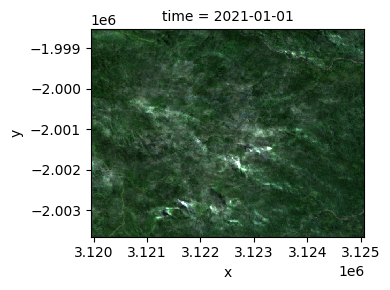

In [25]:
# Extract coordinate system from first item
epsg = items[0].properties["proj:epsg"]

# Convert point from lon/lat to UTM projection
poidf = gpd.GeoDataFrame(crs="OGC:CRS84", geometry=[area_of_interest.centroid]).to_crs(
    epsg
)
geom = poidf.iloc[0].geometry

# Create bounds of the correct size, the model
# requires 512x512 pixels at 10m resolution.
bounds = (geom.x - 2560, geom.y - 2560, geom.x + 2560, geom.y + 2560)

# Retrieve the pixel values, for the bounding box in
# the target projection. In this example we use only
# the RGB and NIR band groups.
stack = stackstac.stack(
    items,
    bounds=bounds,
    snap_bounds=False,
    epsg=epsg,
    resolution=10,
    dtype="float32",
    rescale=False,
    fill_value=0,
    assets=BAND_GROUPS["rgb"] + BAND_GROUPS["nir"],
    resampling=Resampling.nearest,
)

stack = stack.compute()
assert stack.shape == (1, 4, 512, 512)

stack.sel(band=["B04", "B03", "B02"]).plot.imshow(
    row="time", rgb="band", vmin=0, vmax=2000
)

### Get the geospatial bounds for the 32x32 windows 
(which we will use for the patch bboxes)

In [ ]:
# Define the chunk size for tiling
chunk_size = {'x': 32, 'y': 32}  # Adjust the chunk size as needed

# Tile the data
ds_chunked = stack.chunk(chunk_size)

# Get the dimensions of the data array
dims = ds_chunked.dims

# Get the geospatial information from the original dataset
geo_info = ds_chunked.attrs

# Iterate over the chunks and compute the geospatial bounds for each chunk
chunk_bounds = {}

# Get the geospatial transform and CRS
transform = ds_chunked.attrs['transform']
crs = ds_chunked.attrs['crs']

for x in range((ds_chunked.sizes['x'] // chunk_size['x']) + 1):
    for y in range((ds_chunked.sizes['y'] // chunk_size['y']) + 1):
        # Compute chunk coordinates
        x_start = x * chunk_size['x']
        y_start = y * chunk_size['y']
        x_end = min(x_start + chunk_size['x'], ds_chunked.sizes['x'])
        y_end = min(y_start + chunk_size['y'], ds_chunked.sizes['y'])
        
        # Compute chunk geospatial bounds
        lon_start, lat_start = transform * (x_start, y_start)
        lon_end, lat_end = transform * (x_end, y_end)

        # Store chunk bounds
        chunk_bounds[(x, y)] = {
            'lon_start': lon_start, 'lat_start': lat_start,
            'lon_end': lon_end, 'lat_end': lat_end
        }

# Print chunk bounds
for key, value in chunk_bounds.items():
    print(f"Chunk {key}: {value}")



In [30]:
outdir = Path("data/minicubes")
outdir.mkdir(exist_ok=True, parents=True)

# Write tile to output dir
for tile in stack:
    date = str(tile.time.values)[:10]

    name = "{dir}/claytile_{date}.tif".format(
        dir=outdir,
        date=date.replace("-", ""),
    )
    tile.rio.to_raster(name, compress="deflate")

    with rasterio.open(name, "r+") as rst:
        rst.update_tags(date=date)


In [31]:
DATA_DIR = "data/minicubes"
CKPT_PATH = "/home/ubuntu/data/checkpoints/mae_epoch-24_val-loss-0.46.ckpt"

# Load model
multi_model = CLAYModule.load_from_checkpoint(
    CKPT_PATH,
    mask_ratio=0.0,
    band_groups={"rgb": (2, 1, 0), "nir": (3,)},
    bands=4,
    strict=False,  # ignore the extra parameters in the checkpoint
)
# Set the model to evaluation mode
multi_model.eval()


# Load the datamodule, with the reduced set of
class ClayDataModuleMulti(ClayDataModule):
    MEAN = [
        1369.03,  # red
        1597.68,  # green
        1741.10,  # blue
        2893.86,  # nir
    ]
    STD = [
        2026.96,  # red
        2011.88,  # green
        2146.35,  # blue
        1917.12,  # nir
    ]


data_dir = Path(DATA_DIR)

dm = ClayDataModuleMulti(data_dir=str(data_dir.absolute()), batch_size=1)
dm.setup(stage="predict")
trn_dl = iter(dm.predict_dataloader())

Total number of chips: 1


/opt/conda/envs/pytorch_custom/lib/python3.10/site-packages/lightning/pytorch/core/saving.py:177: Found keys that are not in the model state dict but in the checkpoint: ['model.encoder.patch_embedding.rededge.proj.weight', 'model.encoder.patch_embedding.rededge.proj.bias', 'model.encoder.patch_embedding.rededge.norm.weight', 'model.encoder.patch_embedding.rededge.norm.bias', 'model.encoder.patch_embedding.swir.proj.weight', 'model.encoder.patch_embedding.swir.proj.bias', 'model.encoder.patch_embedding.swir.norm.weight', 'model.encoder.patch_embedding.swir.norm.bias', 'model.encoder.patch_embedding.sar.proj.weight', 'model.encoder.patch_embedding.sar.proj.bias', 'model.encoder.patch_embedding.sar.norm.weight', 'model.encoder.patch_embedding.sar.norm.bias', 'model.encoder.patch_embedding.dem.proj.weight', 'model.encoder.patch_embedding.dem.proj.bias', 'model.encoder.patch_embedding.dem.norm.weight', 'model.encoder.patch_embedding.dem.norm.bias', 'model.decoder.embed_to_pixels.rededge.wei

In [32]:
embeddings = []
for batch in trn_dl:
    with torch.no_grad():
        # Move data from to the device of model
        batch["pixels"] = batch["pixels"].to(multi_model.device)
        # Pass just the specific band through the model
        batch["timestep"] = batch["timestep"].to(multi_model.device)
        batch["latlon"] = batch["latlon"].to(multi_model.device)

        # Pass pixels, latlon, timestep through the encoder to create encoded patches
        (
            unmasked_patches,
            unmasked_indices,
            masked_indices,
            masked_matrix,
        ) = multi_model.model.encoder(batch)
        print(unmasked_patches.detach().cpu().numpy())

        embeddings.append(unmasked_patches.detach().cpu().numpy())

#embeddings = numpy.vstack(embeddings)
print(len(embeddings[0]))

#embeddings_mean = embeddings[:, :-2, :].mean(axis=1)

[[[-0.00138722  0.00553577  0.00661551 ...  0.00693459  0.03910097
   -0.03037707]
  [ 0.00335213  0.04459351  0.00697042 ... -0.01664061 -0.00127563
   -0.04094137]
  [-0.00115948  0.05494894  0.01314757 ... -0.00202933  0.01157284
   -0.00657634]
  ...
  [ 0.01001669  0.04902903 -0.00219882 ... -0.00756053  0.01837982
   -0.00212315]
  [ 0.00234538  0.05262276  0.01024936 ...  0.00485022 -0.00019792
    0.0364737 ]
  [ 0.01439271  0.08187232 -0.00578502 ... -0.05577405  0.02140757
   -0.04572564]]]
1


In [34]:
embeddings[0].shape

(1, 514, 768)

### Read the mining extraction ground truth points
We will use these for reference in a similarity search.

In [35]:
mrd = gpd.read_file("../mineral-resource-detection/training_data/draft_inputs/MRD_dissagregated_25.geojson")

In [ ]:
mrd

In [21]:
mrd.lulc_class.unique()

array(['forest', 'grassland', 'bare_land', 'crops', 'quarry', 'water',
       'settlements', 'mangroves'], dtype=object)

In [24]:
mrd.crs.to_epsg()

4326

In [22]:
epsg

3832

In [25]:
mrd = mrd.to_crs(epsg)

In [26]:
mrd.crs.to_epsg()

3832